In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Helpful Functions

In [2]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,tensorflow_hub as hub
import numpy as np,pylab as pl,PIL.Image
file_path='https://olgabelitskaya.gitlab.io/images/'

In [3]:
def low2superbicubic_imgs(lr,sr):
    pl.figure(figsize=(8,4));pl.title('LR')
    pl.imshow(lr.numpy()); pl.show(); print()
    pl.figure(figsize=(8,4))
    pl.subplot(1,2,1); pl.title(f'ESRGAN (x4)')
    pl.imshow(sr.numpy());
    img_size=lr.shape[1]
    bicubic=tf.image.resize(
        lr,[img_size*4,img_size*4],tf.image.ResizeMethod.BICUBIC)
    bicubic=tf.cast(bicubic, tf.uint8)
    pl.subplot(1,2,2); pl.title('Bicubic')
    pl.imshow(bicubic.numpy())
    pl.tight_layout(); pl.show()

In [4]:
%radial_gradient_header Image Data for Super Resolution

In [5]:
img_path=file_path+'04_001.png'
img_path=tf.keras.utils.get_file('04_001.png',img_path)

16384/12115 [========================================] - 0s 0us/step


In [6]:
%radial_gradient_header Model Loading

In [7]:
model=hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
func.inputs[0].set_shape([1,50,50,3])
converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model=converter.convert()
with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
    f.write(tflite_model)
esrgan_model_path='./ESRGAN.tflite'

In [8]:
%radial_gradient_header ESRGAN Interpreter

In [9]:
lr=tf.io.read_file(img_path)
lr=tf.image.decode_jpeg(lr)
lr=tf.image.resize(lr,[50,50])
lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
lr=tf.cast(lr,tf.float32)
interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'],lr)
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
sr=tf.squeeze(output_data,axis=0)
sr=tf.clip_by_value(sr,0,255)
sr=tf.round(sr); sr=tf.cast(sr,tf.uint8)
lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)

In [10]:
%radial_gradient_header Super Resolution

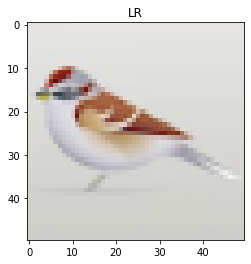

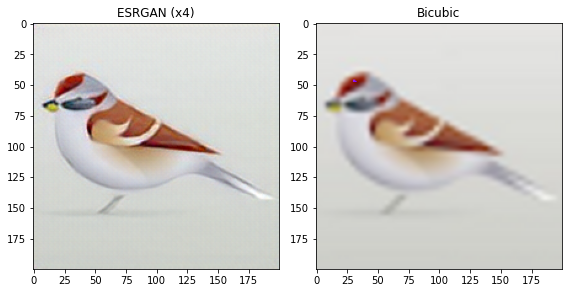

In [11]:
low2superbicubic_imgs(lr,sr) 

In [12]:
%radial_gradient_header Super Resolution Function

In [13]:
%%writefile esrgantf2_superresolution.py
import tensorflow as tf,tensorflow_hub as hub,numpy as np
def esrgantf2_superresolution(img_path,img_size=50):
    model=hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[0].set_shape([1,img_size,img_size,3])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    img_path=tf.keras.utils.get_file('img.png',img_path)
    lr=tf.io.read_file(img_path)
    lr=tf.image.decode_jpeg(lr)
    lr=tf.image.resize(lr,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
    lr=tf.cast(lr,tf.float32)
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[0]['index'])
    sr=tf.squeeze(output_data,axis=0)
    sr=tf.clip_by_value(sr,0,255)
    sr=tf.round(sr); sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)
    return lr,sr

Writing esrgantf2_superresolution.py


16384/12115 [========================================] - 0s 0us/step


<Figure size 432x288 with 0 Axes>

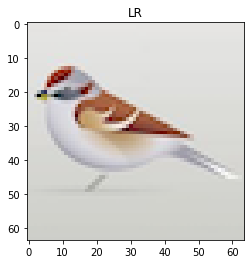

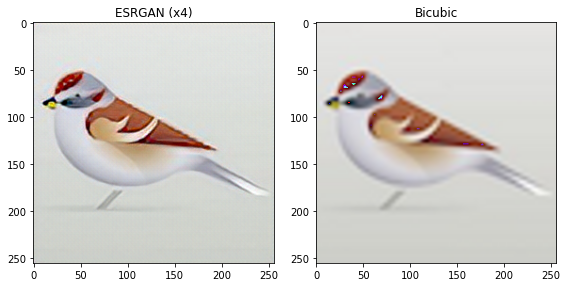

In [14]:
%run esrgantf2_superresolution.py
lr,sr=esrgantf2_superresolution(file_path+'04_001.png',64)
low2superbicubic_imgs(lr,sr)